In [1]:
import os
import cv2
import time
import random
import numpy as np
import zipfile

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
random.seed(3)
np.random.seed(3)
tf.random.set_seed(3)

ROOT = "/content/drive/MyDrive/Siamese Face Recognition"
KAGGLE_ROOT = ROOT+'/data/kaggle/Extracted Faces'
INTERNET_ROOT = ROOT+'/data/internet/Extracted'
MODEL_ROOT = ROOT + '/model-siamese'

load_model = True
save_all = True
path = "training"
checkpoint_path = os.path.join(MODEL_ROOT, path)
checkpoint_dir = os.path.dirname(checkpoint_path)
epochs = 10

# Data ETL

In [4]:
# with zipfile.ZipFile(ROOT+'/kaggle/Kaggle_Dataset_Face_Recognition.zip', 'r') as zip_ref:
#     zip_ref.extractall(ROOT+'/kaggle')

In [5]:
def get_num_files(directory, folders):
  ret_map = {}

  for folder in folders:
    num_files = len(os.listdir(os.path.join(directory, folder)))
    ret_map[folder] = num_files
  
  return ret_map

def split_dataset(directory, train_size=0.9):
  folders = os.listdir(directory)
  random.shuffle(folders)

  cut = int(len(folders) * train_size)

  train_map = get_num_files(directory, folders[:cut])
  test_map = get_num_files(directory, folders[cut:])

  return train_map, test_map

In [6]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                try:
                  anchor = (directory, folder, files[i])
                  positive = (directory, folder, files[j])

                  neg_folder = random.choice(folders)
                  while neg_folder == folder:
                    neg_folder = random.choice(folders)
                  
                  neg_file = random.choice(os.listdir(os.path.join(directory, neg_folder)))
                  negative = (directory, neg_folder, neg_file)

                  triplets.append((anchor, positive, negative))
                except:
                  pass
            
    random.shuffle(triplets)
    return triplets

In [7]:
def brightness(img, brightness):
    value = random.uniform(float(1/brightness), brightness)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

def horizontal_flip(img, flag):
    if flag == 1:
        return cv2.flip(img, 1)
    else:
        return img
  
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

def read_image(idx, brightness_val=2, hflip=True, rotation_val=20):
    path = os.path.join(idx[0], idx[1], idx[2])
    image = cv2.imread(path)
    image = cv2.resize(image, (128, 128))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = brightness(image, brightness_val)
    if(hflip == True):
      image = horizontal_flip(image, random.randint(0, 1))
    image = rotation(image, rotation_val)
    
    return image

In [8]:
def get_batch(triplet_list, batch_size=256, brightness_val=2, hflip=True, rotation_val=20):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a, brightness_val=brightness_val, hflip=hflip, rotation_val=rotation_val))
            positive.append(read_image(p, brightness_val=brightness_val, hflip=hflip, rotation_val=rotation_val))
            negative.append(read_image(n, brightness_val=brightness_val, hflip=hflip, rotation_val=rotation_val))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        yield ([anchor, positive, negative])

### From Kaggle Source

In [9]:
train_list_kaggle, test_list_kaggle = split_dataset(KAGGLE_ROOT, train_size=1)
print("Length of training list:", len(train_list_kaggle))
print("Length of testing list :", len(test_list_kaggle))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", train_list_kaggle)

Length of training list: 1324
Length of testing list : 0

Test List: {'642': 3, '649': 12, '1025': 5, '1147': 2, '1232': 2, '1456': 2, '173': 5, '912': 3, '1022': 3, '880': 2, '535': 2, '1291': 3, '1587': 3, '245': 5, '323': 2, '1389': 8, '78': 2, '1453': 2, '339': 2, '300': 5, '422': 4, '1092': 17, '205': 12, '675': 3, '172': 2, '1554': 7, '902': 5, '8': 4, '1677': 3, '626': 2, '1332': 13, '1314': 2, '352': 3, '607': 7, '929': 2, '875': 2, '1307': 4, '1243': 3, '960': 2, '390': 45, '564': 2, '266': 6, '733': 3, '755': 9, '322': 4, '1534': 2, '168': 2, '171': 14, '852': 2, '1439': 3, '816': 3, '695': 3, '693': 3, '148': 2, '579': 5, '330': 2, '1228': 2, '1611': 4, '713': 2, '196': 2, '1193': 2, '1066': 2, '813': 2, '1181': 6, '1582': 2, '1657': 3, '734': 5, '868': 7, '497': 3, '588': 23, '932': 2, '1230': 2, '961': 3, '1365': 2, '1477': 3, '1174': 4, '464': 2, '488': 2, '860': 2, '1617': 2, '351': 2, '1002': 3, '658': 10, '1596': 2, '1433': 20, '837': 2, '1567': 4, '1244': 2, '864': 5,

In [10]:
train_triplet_kaggle = create_triplets(KAGGLE_ROOT, train_list_kaggle)
test_triplet_kaggle  = create_triplets(KAGGLE_ROOT, test_list_kaggle)

print("Number of training triplets:", len(train_triplet_kaggle))
print("Number of testing triplets :", len(test_triplet_kaggle))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet_kaggle[i])

Number of training triplets: 11231
Number of testing triplets : 0

Examples of triplets:
(('/content/drive/MyDrive/Siamese Face Recognition/data/kaggle/Extracted Faces', '1666', '13.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/kaggle/Extracted Faces', '1666', '4.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/kaggle/Extracted Faces', '399', '0.jpg'))
(('/content/drive/MyDrive/Siamese Face Recognition/data/kaggle/Extracted Faces', '605', '0.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/kaggle/Extracted Faces', '605', '1.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/kaggle/Extracted Faces', '1528', '0.jpg'))
(('/content/drive/MyDrive/Siamese Face Recognition/data/kaggle/Extracted Faces', '1092', '14.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/kaggle/Extracted Faces', '1092', '13.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/kaggle/Extracted Faces', '0', '2.jpg'))
(('/content/drive/MyDrive/Sia

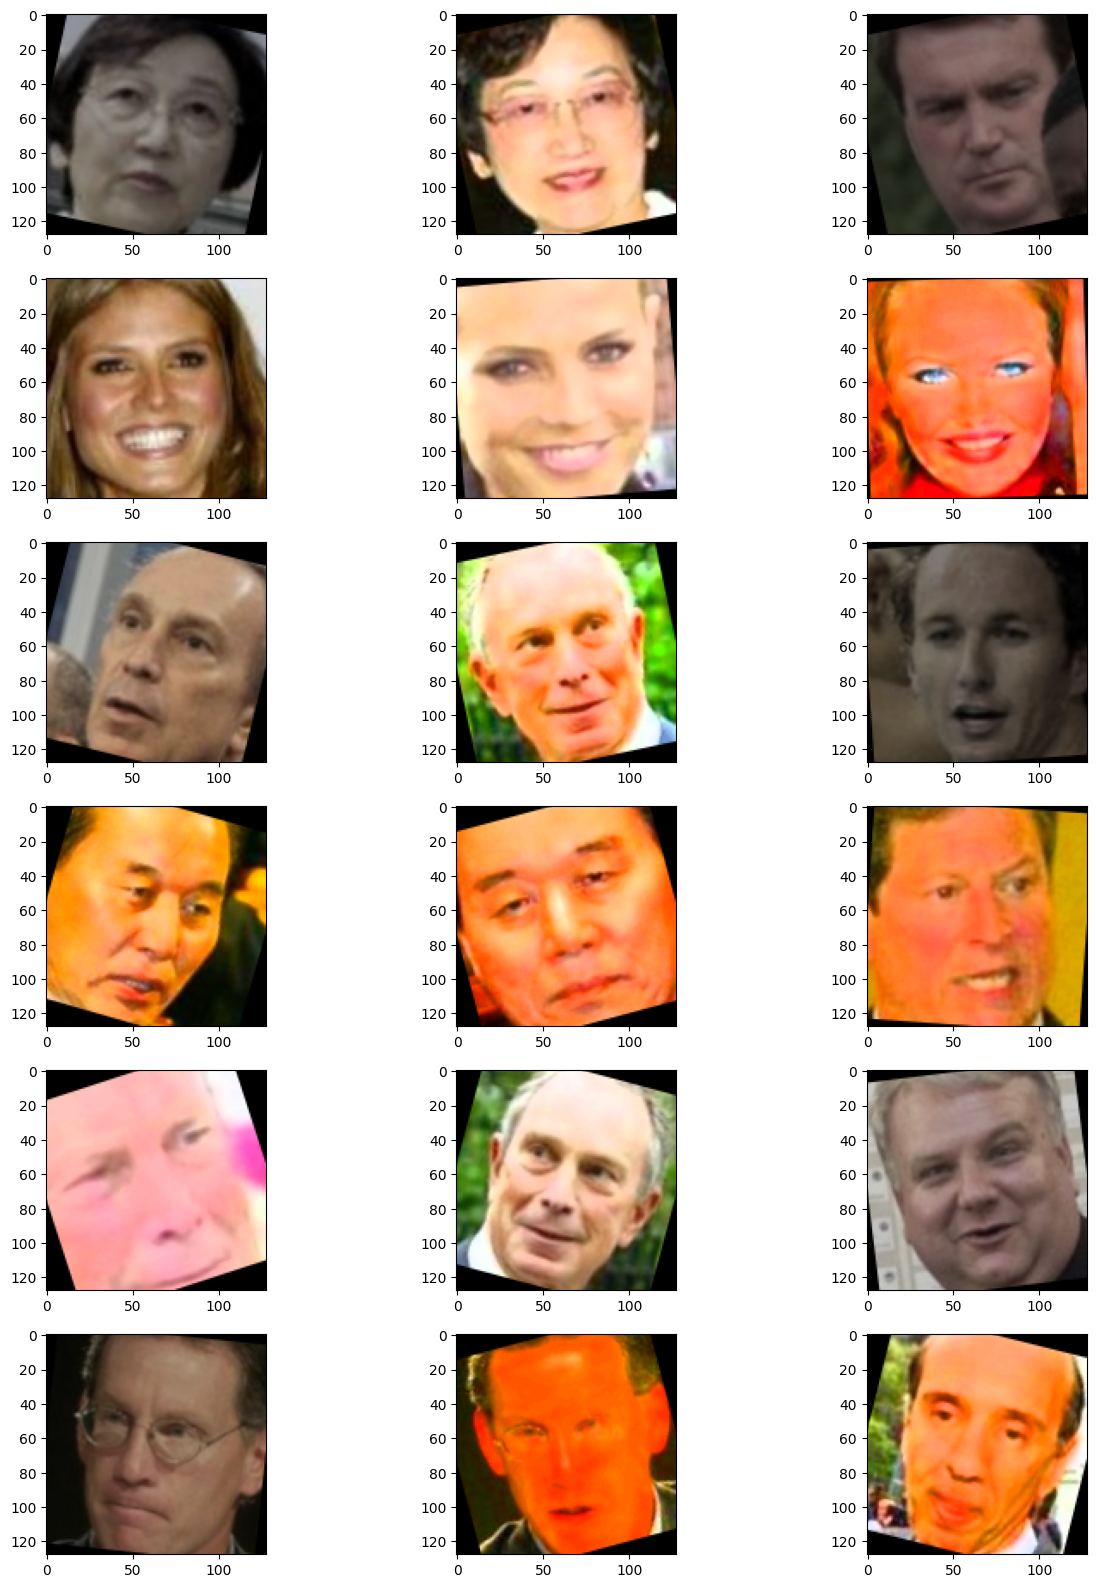

In [11]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet_kaggle, batch_size=num_plots):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

### From Internet Source

In [12]:
train_list_internet, test_list_internet = split_dataset(INTERNET_ROOT, train_size=0.5)
print("Length of training list:", len(train_list_internet))
print("Length of testing list :", len(test_list_internet))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list_internet)

Length of training list: 49
Length of testing list : 50

Test List: {'Ernando_Ari': 8, 'Abdel_Achrian': 3, 'Reza_Oktovian': 5, 'Vina_Panduwinata': 10, 'Komang_Ayu_Cahya_Dewi': 4, 'Cak_Lontong': 7, 'Ge_Pamungkas': 6, 'Isyana_Sarasvati': 7, 'Bayu_Skak': 5, 'Mohammad_Ahsan': 5, 'Prabowo_Subianto': 4, 'Andovi_Da_Lopez': 7, 'Dewi_Lestari': 5, 'Elvy_Sukaesih': 5, 'Gilang_Dirga': 5, 'Jess_No_Limit': 7, 'Muhammad_Rian_Ardianto': 4, 'Rich_Brian': 5, 'Lyodra_Ginting': 7, 'tanboy_kun': 8, 'Tulus': 6, 'Inul_Daratista': 7, 'Indah_Dewi_Pertiwi': 9, 'Fajar_Alfian': 4, 'Alfeandra_Dewangga': 5, 'Julia_Perez': 7, 'Dewi_Sandra': 6, 'Chrisye': 4, 'Sherina_Munaf': 9, 'Aurel_Hermansyah': 4, 'Arie_Kriting': 2, 'Agnez_Mo': 9, 'Nike_Ardilla': 8, 'Brian_Imanuel': 7, 'Ebiet_G_Ade': 8, 'Wilda_Siti_Nurfadhila': 4, 'Ari_Lasso': 3, 'Bintang_Emon': 6, 'Glenn_Fredly': 3, 'Chandra_Liow': 9, 'Anggun': 9, 'Megawati_Hangestri_P': 5, 'Fatin_Shidqia': 8, 'Edho_Zell': 6, 'Citra_Scholastika': 8, 'Jonatan_Christie': 10, 'Irfan

In [13]:
train_triplet_internet = create_triplets(INTERNET_ROOT, train_list_internet)
test_triplet_internet  = create_triplets(INTERNET_ROOT, test_list_internet)

print("Number of training triplets:", len(train_triplet_internet))
print("Number of testing triplets :", len(test_triplet_internet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet_internet[i])

Number of training triplets: 1026
Number of testing triplets : 914

Examples of triplets:
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Yuni_Shara', '5.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Yuni_Shara', '11.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Hanin_Dhiya', '13.jpg'))
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Jerome_Polin', '9.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Jerome_Polin', '15.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Puan_Maharani', '14.jpg'))
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Joko_Widodo', '11.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Joko_Widodo', '19.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'David_Nurbiant

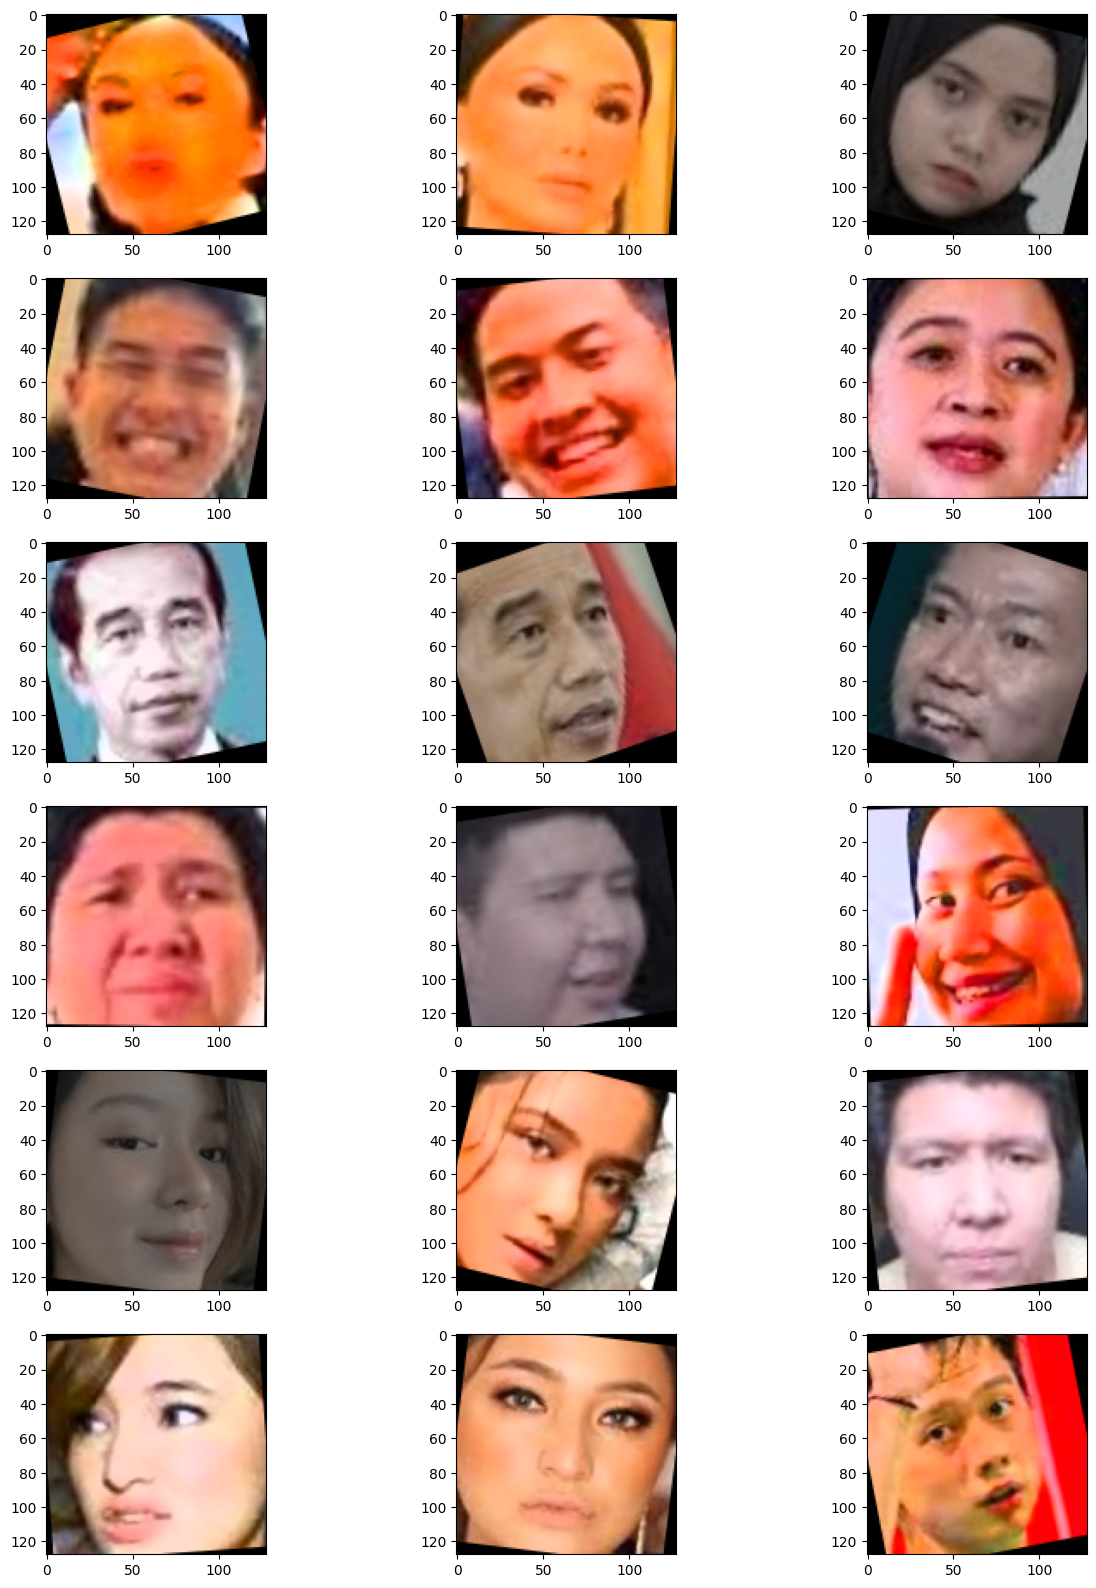

In [14]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet_internet, batch_size=num_plots):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [15]:
# Joining train list
train_triplet = train_triplet_internet + train_triplet_kaggle
test_triplet = test_triplet_internet

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 12257
Number of testing triplets : 914

Examples of triplets:
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Yuni_Shara', '5.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Yuni_Shara', '11.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Hanin_Dhiya', '13.jpg'))
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Jerome_Polin', '9.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Jerome_Polin', '15.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Puan_Maharani', '14.jpg'))
(('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Joko_Widodo', '11.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'Joko_Widodo', '19.jpg'), ('/content/drive/MyDrive/Siamese Face Recognition/data/internet/Extracted', 'David_Nurbian

# Model Building

In [16]:
import tensorflow as tf
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [17]:
def build_encoder(input_shape):

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='max',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = True

    model_encoder = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Model_Encoder")

    return model_encoder

In [18]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        
        return (ap_distance, an_distance)

In [19]:
def build_siamese_network(input_shape = (128, 128, 3)):
    encoder = build_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    # Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoded_a,
        encoded_p,
        encoded_n
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )

    return siamese_network

In [20]:
siamese_network = build_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                   

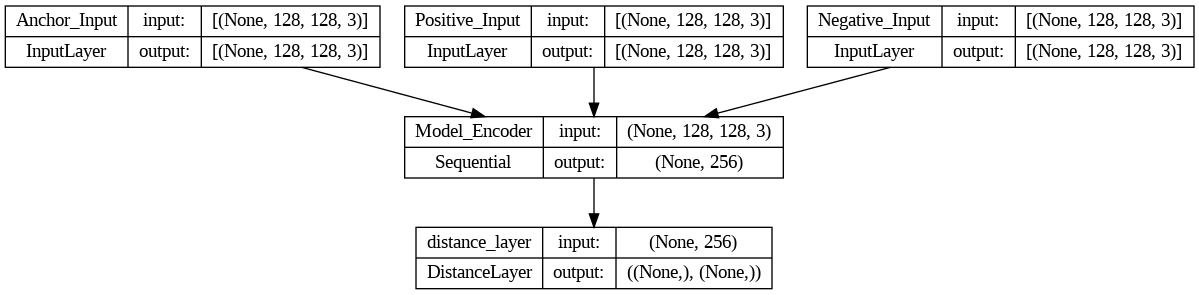

In [21]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [22]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]
        
    def save_weights(self, path):
      self.siamese_network.save_weights(path)

    def load_weights(self, path):
      self.siamese_network.load_weights(path)

In [23]:
siamese_model = SiameseModel(siamese_network)
if(load_model):
  try:
    siamese_model.load_weights(load_path)
  except:
    print("Failed to load model weigth, using default model")
    pass

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

Failed to load model weigth, using default model


# Model Training

In [24]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size, brightness_val=1, hflip=False, rotation_val=0):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [25]:
batch_size = 64

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    # print(f"EPOCH {epoch}: ", end='')
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights('siamese-network-{epoch:04d}.h5')
        max_acc = accuracy

# Saving the model after all epochs run
siamese_model.save_weights('siamese-network-final.h5')


EPOCH: 1 	 (Epoch done in 3505 sec)
Loss on train    = 0.88564
1/1 [==============================] - 3s 3s/step
Accuracy on test = 0.60394

EPOCH: 2 	 (Epoch done in 289 sec)
Loss on train    = 0.77015
1/1 [==============================] - 0s 32ms/step
Accuracy on test = 0.56893

EPOCH: 3 	 (Epoch done in 288 sec)
Loss on train    = 0.69805
1/1 [==============================] - 0s 42ms/step
Accuracy on test = 0.59519

EPOCH: 4 	 (Epoch done in 287 sec)
Loss on train    = 0.64202
1/1 [==============================] - 0s 33ms/step
Accuracy on test = 0.67615

EPOCH: 5 	 (Epoch done in 288 sec)
Loss on train    = 0.57673
1/1 [==============================] - 0s 31ms/step
Accuracy on test = 0.70569

EPOCH: 6 	 (Epoch done in 287 sec)
Loss on train    = 0.54943
1/1 [==============================] - 0s 46ms/step
Accuracy on test = 0.73632

EPOCH: 7 	 (Epoch done in 288 sec)
Loss on train    = 0.49586
1/1 [==============================] - 0s 31ms/step
Accuracy on test = 0.75821

EPOCH:

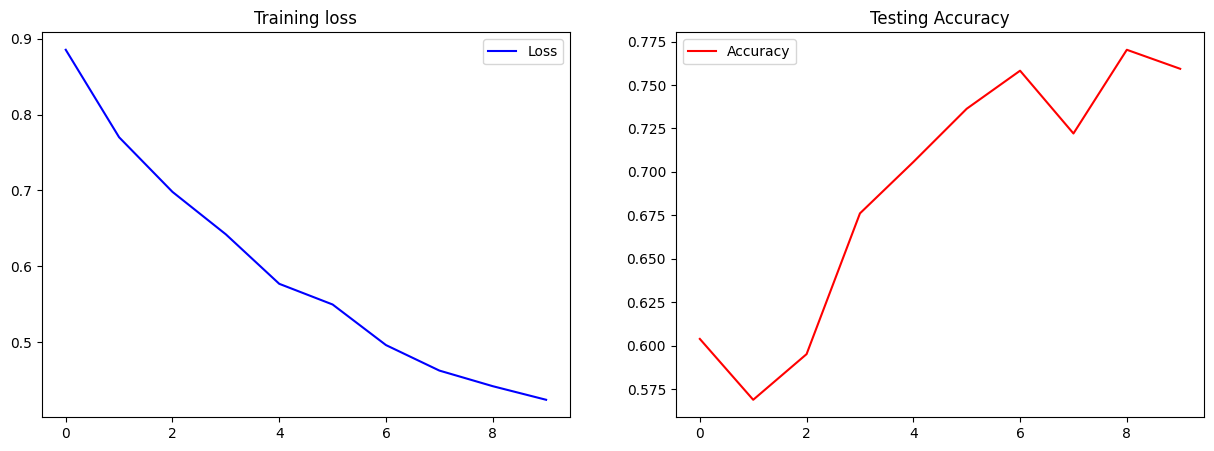

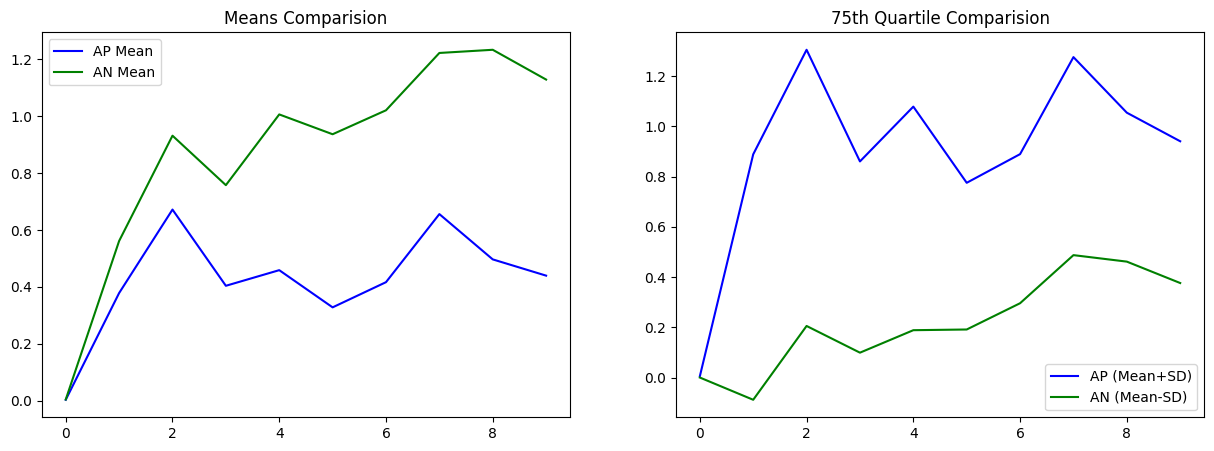

In [26]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

In [27]:
def extract_encoder(model):
    encoder = build_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Model_Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                     

In [28]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

8/8 [==============================] - 0s 39ms/step

Accuracy of model: 0.673828125



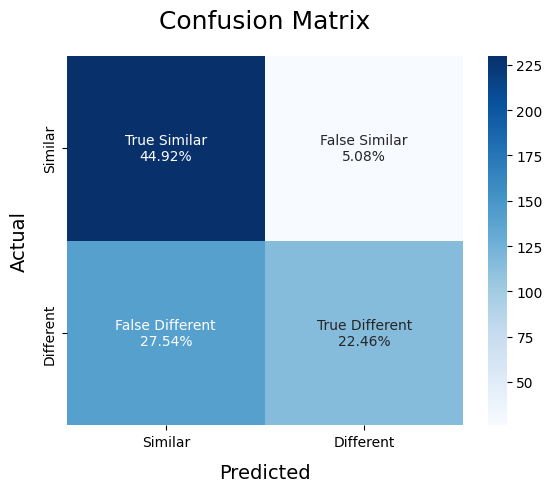

In [29]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256, brightness_val=1, hflip=False, rotation_val=0):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)